In [22]:
import pandas as pd

df = pd.read_csv(r'C:\Users\menyc\Documents\Projects\bipolar_disorter_alert_ml_mechanism\bipolar_disorter_alert_mechanism\data\daily_features_cleaned.csv')

The system uses an autoencoder trained exclusively on non-relapse (label = 0) data from a specific patient to learn typical behavioral patterns. During inference, it calculates the reconstruction loss for each day and triggers an alert if this loss exceeds a predefined threshold. The model was evaluated using both normal and relapse-labeled data from the same patient, with performance assessed based on the number of correctly identified alerts and false positives. As will be shown, the model successfully identifies anomalies during a severe relapse period, demonstrating its potential. However, this implementation should be viewed as a proof of concept. To develop a more sophisticated and clinically useful version, significantly more data from a broader population of patients will be necessary, allowing for more complex modeling approaches and individualized detection strategies.

In [25]:
# StandardScaler (Linear activation)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Filter only normal (label == 0) samples for training
df_filtered = df[df["label"] == 0].drop(columns=["label", "date"])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)

# Train/test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Define autoencoder
input_dim = X_train.shape[1]
encoding_dim = 10

autoencoder = models.Sequential([
    layers.GaussianNoise(0.05, input_shape=(input_dim,)),  # FIXED
    # layers.Input(shape=(input_dim,)),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(input_dim, activation='tanh')
])

# autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer='adam', loss='mae')

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=[early_stop],
                          verbose=1)

print(" Autoencoder training complete.")


Epoch 1/100


C:\Users\menyc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6254 - val_loss: 0.5656
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5674 - val_loss: 0.5347
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5612 - val_loss: 0.5081
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5160 - val_loss: 0.4836
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4855 - val_loss: 0.4619
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4792 - val_loss: 0.4424
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4643 - val_loss: 0.4246
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4586 - val_loss: 0.4081
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4409 - val_loss: 0.3933
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4323 - val_loss: 0.3793
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4116 - val_loss: 0.3668
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3807 - val_lo

**Step 2: Compute Reconstruction Errors for All Samples (Label 0 and 1)**

In [27]:
import numpy as np

# Drop label and date for reconstruction
df_features = df.drop(columns=["label", "date"])
X_all_scaled = scaler.transform(df_features)

# Predict reconstructed inputs
X_pred = autoencoder.predict(X_all_scaled)

# Compute per-feature squared reconstruction error
reconstruction_errors = np.square(X_all_scaled - X_pred)

# Store as DataFrame
df_errors = pd.DataFrame(reconstruction_errors, columns=df_features.columns)

# Reattach metadata for evaluation
df_errors["label"] = df["label"].values
df_errors["date"] = pd.to_datetime(df["date"])

print(" Reconstruction errors computed for all samples.")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Reconstruction errors computed for all samples.


**Step 3: Check if the label 1 will classify as an anomally**:

Creating a test dataset with equal points from label 0 and 1 to check the reocnstruction loss of the autoencoder pretrained model

In [28]:
import pandas as pd
# Select a sample of label 1 and unseen label 0 data for testing
df_label_1 = df[df['label'] == 1]
df_label_0_sample = df[df['label'] == 0].sample(n=len(df_label_1), random_state=42) # Sample same number of 0s as 1s
df_test_sample = pd.concat([df_label_1, df_label_0_sample])

# Separate features and labels for the test sample
X_test_sample = df_test_sample.drop(columns=['label', 'date'])
y_test_sample = df_test_sample['label']

# Scale the test sample data using the same scaler fitted on the training data (label 0)
X_test_sample_scaled = scaler.transform(X_test_sample)

# Predict reconstructions for the test sample
X_test_sample_pred = autoencoder.predict(X_test_sample_scaled)

# Calculate reconstruction loss (Mean Squared Error) for the test sample
mse = tf.keras.losses.MeanSquaredError()
reconstruction_losses = tf.reduce_mean(tf.square(X_test_sample_scaled - X_test_sample_pred), axis=1).numpy()

# Add reconstruction loss to the test sample DataFrame
df_test_sample['reconstruction_loss'] = reconstruction_losses


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Visualize the distribution of reconstruction losses for different labels

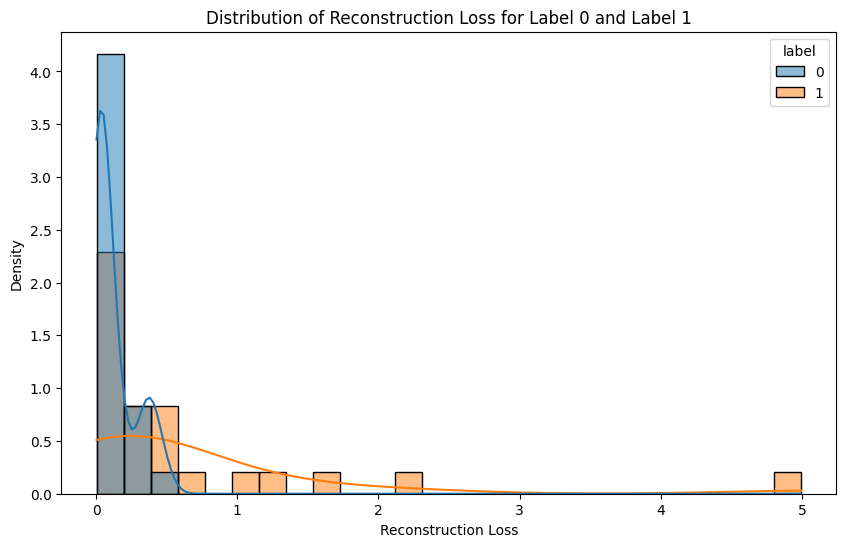


Reconstruction Loss Statistics by Label:
       count      mean       std       min       25%       50%       75%  \
label                                                                      
0       25.0  0.114066  0.145154  0.002586  0.016138  0.049003  0.159498   
1       25.0  0.612587  1.065446  0.002982  0.020378  0.375734  0.522687   

           max  
label           
0      0.46307  
1      4.99363  


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_test_sample, x='reconstruction_loss', hue='label', kde=True, stat='density', common_norm=False)
plt.title('Distribution of Reconstruction Loss for Label 0 and Label 1')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.show()

print("\nReconstruction Loss Statistics by Label:")
print(df_test_sample.groupby('label')['reconstruction_loss'].describe())


To determine if the autoencoder predicts label 1 as an anomaly,
we need *** significantly higher reconstruction losses***
for data points with label 1 compared to those with label 0.

Let's set a threshold based on the distribution of losses for label 0 (e.g., mean + n*std_dev or a percentile) and see how many label 1 samples
fall above that threshold.

In [30]:
# Example: Set a threshold based on the 95th percentile of reconstruction loss for label 0
threshold = df_test_sample[df_test_sample['label'] == 0]['reconstruction_loss'].quantile(0.95)
print(f"\nThreshold based on 95th percentile of label 0 reconstruction loss: {threshold:.4f}")

# Count how many samples with label 1 have reconstruction loss above the threshold
anomalies_predicted = df_test_sample[(df_test_sample['reconstruction_loss'] > threshold) & (df_test_sample['label'] == 1)].shape[0]
total_label_1 = df_test_sample[df_test_sample['label'] == 1].shape[0]

print(f"\nNumber of label 1 samples with reconstruction loss > threshold: {anomalies_predicted}")
print(f"Total number of label 1 samples in the test sample: {total_label_1}")
print(f"Percentage of label 1 samples predicted as anomalies: {(anomalies_predicted / total_label_1) * 100:.2f}%")

# Count how many samples with label 0 are incorrectly predicted as anomalies
false_positives = df_test_sample[(df_test_sample['reconstruction_loss'] > threshold) & (df_test_sample['label'] == 0)].shape[0]
total_label_0 = df_test_sample[df_test_sample['label'] == 0].shape[0]

print(f"Number of label 0 samples with reconstruction loss > threshold (false positives): {false_positives}")
print(f"Total number of label 0 samples in the test sample: {total_label_0}")
print(f"Percentage of label 0 samples predicted as anomalies (false positive rate): {(false_positives / total_label_0) * 100:.2f}%")



Threshold based on 95th percentile of label 0 reconstruction loss: 0.3774

Number of label 1 samples with reconstruction loss > threshold: 12
Total number of label 1 samples in the test sample: 25
Percentage of label 1 samples predicted as anomalies: 48.00%
Number of label 0 samples with reconstruction loss > threshold (false positives): 2
Total number of label 0 samples in the test sample: 25
Percentage of label 0 samples predicted as anomalies (false positive rate): 8.00%


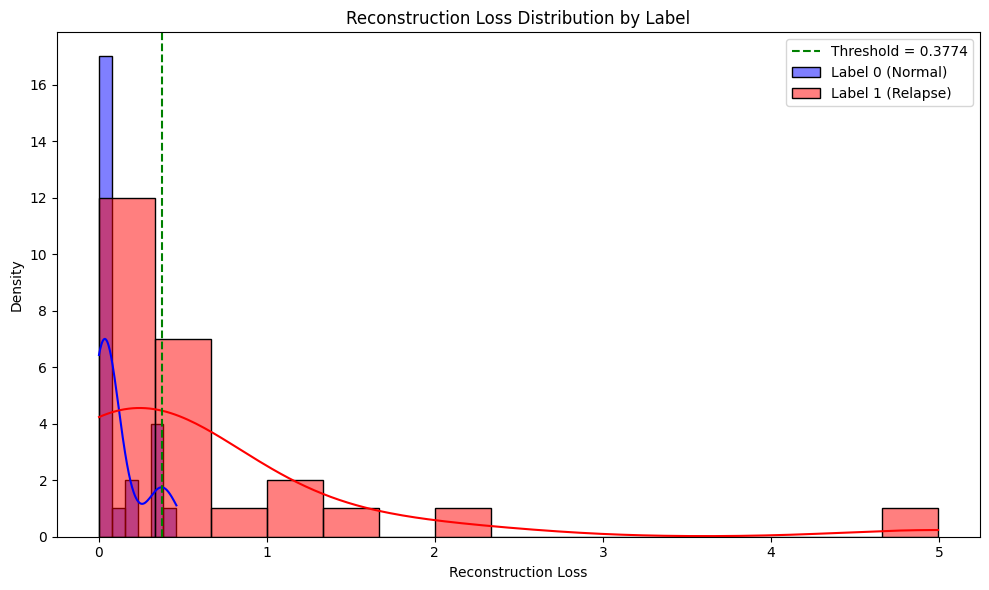

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df_test_sample[df_test_sample['label'] == 0]['reconstruction_loss'],
             color='blue', label='Label 0 (Normal)', kde=True)
sns.histplot(df_test_sample[df_test_sample['label'] == 1]['reconstruction_loss'],
             color='red', label='Label 1 (Relapse)', kde=True)
plt.axvline(x=threshold, color='green', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.title('Reconstruction Loss Distribution by Label')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

Lets try to improve catching more anomalies by lowering the thresshold

In [32]:
# Example: Set a threshold based on the 98th percentile of reconstruction loss for label 0
threshold = df_test_sample[df_test_sample['label'] == 0]['reconstruction_loss'].quantile(0.98)
print(f"\nThreshold based on 98th percentile of label 0 reconstruction loss: {threshold:.4f}")

# Count how many samples with label 1 have reconstruction loss above the threshold
anomalies_predicted = df_test_sample[(df_test_sample['reconstruction_loss'] > threshold) & (df_test_sample['label'] == 1)].shape[0]
total_label_1 = df_test_sample[df_test_sample['label'] == 1].shape[0]

print(f"\nNumber of label 1 samples with reconstruction loss > threshold: {anomalies_predicted}")
print(f"Total number of label 1 samples in the test sample: {total_label_1}")
print(f"Percentage of label 1 samples predicted as anomalies: {(anomalies_predicted / total_label_1) * 100:.2f}%")

# Count how many samples with label 0 are incorrectly predicted as anomalies
false_positives = df_test_sample[(df_test_sample['reconstruction_loss'] > threshold) & (df_test_sample['label'] == 0)].shape[0]
total_label_0 = df_test_sample[df_test_sample['label'] == 0].shape[0]

print(f"Number of label 0 samples with reconstruction loss > threshold (false positives): {false_positives}")
print(f"Total number of label 0 samples in the test sample: {total_label_0}")
print(f"Percentage of label 0 samples predicted as anomalies (false positive rate): {(false_positives / total_label_0) * 100:.2f}%")



Threshold based on 98th percentile of label 0 reconstruction loss: 0.4220

Number of label 1 samples with reconstruction loss > threshold: 9
Total number of label 1 samples in the test sample: 25
Percentage of label 1 samples predicted as anomalies: 36.00%
Number of label 0 samples with reconstruction loss > threshold (false positives): 1
Total number of label 0 samples in the test sample: 25
Percentage of label 0 samples predicted as anomalies (false positive rate): 4.00%


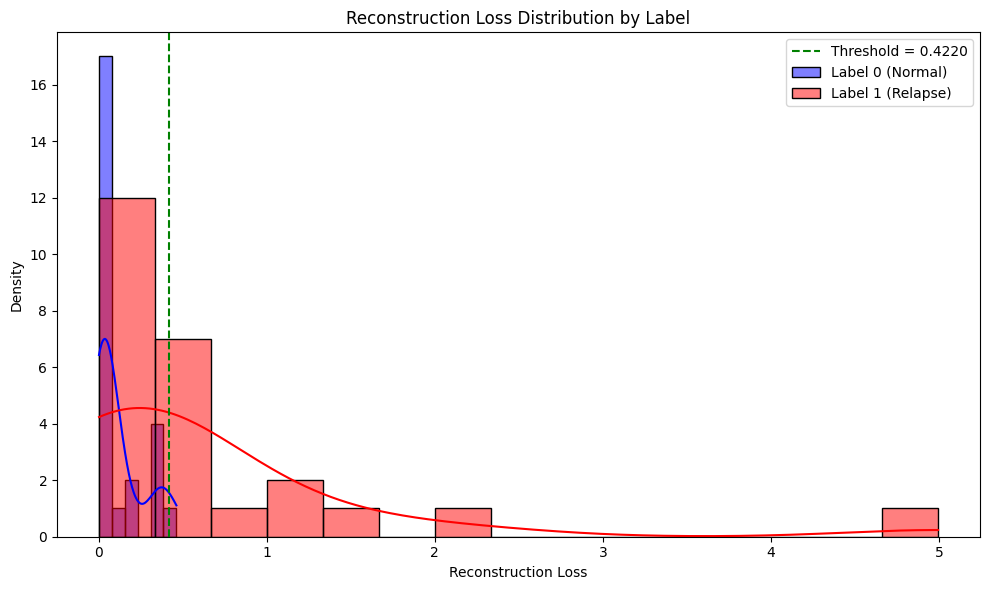

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(df_test_sample[df_test_sample['label'] == 0]['reconstruction_loss'],
             color='blue', label='Label 0 (Normal)', kde=True)
sns.histplot(df_test_sample[df_test_sample['label'] == 1]['reconstruction_loss'],
             color='red', label='Label 1 (Relapse)', kde=True)
plt.axvline(x=threshold, color='green', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.title('Reconstruction Loss Distribution by Label')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

With the above thresshold change Recall decreased: We're missing more real anomalies (7 vs 9 detected).

As we want to catch more anomalies for relapse bipolar prediction, we prefer the 95% threshold as it offers a better balance between sensitivity and specificity — detecting more true positives (36% of label 1 cases) while maintaining a reasonably low false positive rate (8%).

We know from the dataset that the severe symptoms of  the relapse are between "2020-09-30" and "2020-10-29".

So let's test our autoencoder model on the severe symptoms

In [34]:
import pandas as pd

# Define relapse period and anomaly threshold
relapse_start = "2020-09-30"
relapse_end = "2020-10-29"
threshold = df_test_sample[df_test_sample['label'] == 0]['reconstruction_loss'].quantile(0.95)

# Ensure datetime
df_test_sample['date'] = pd.to_datetime(df_test_sample['date'])

# Filter period
df_period = df_test_sample[
    (df_test_sample['date'] >= relapse_start) &
    (df_test_sample['date'] <= relapse_end)
]

# Metrics
relapse_label1 = df_period[df_period['label'] == 1]
total_label_1 = relapse_label1.shape[0]
true_positives = relapse_label1[relapse_label1['reconstruction_loss'] > threshold].shape[0]

normal_label0 = df_period[df_period['label'] == 0]
total_label_0 = normal_label0.shape[0]
false_positives = normal_label0[normal_label0['reconstruction_loss'] > threshold].shape[0]

# Results
print(f"\n Analysis for relapse period: {relapse_start} to {relapse_end}")
print(f"Label 1 samples: {total_label_1}, True Positives: {true_positives} ({(true_positives / total_label_1) * 100:.2f}%)" if total_label_1 else "N/A")
print(f"Label 0 samples: {total_label_0}, False Positives: {false_positives} ({(false_positives / total_label_0) * 100:.2f}%)" if total_label_0 else "N/A")
print(f"Mean loss (label 1): {relapse_label1['reconstruction_loss'].mean():.4f}")
print(f"Median loss (label 1): {relapse_label1['reconstruction_loss'].median():.4f}")



 Analysis for relapse period: 2020-09-30 to 2020-10-29
Label 1 samples: 23, True Positives: 11 (47.83%)
N/A
Mean loss (label 1): 0.4375
Median loss (label 1): 0.3757


Identify featuress that contribute to the anomalies to estimate the model behavioral understanding

In [35]:
import pandas as pd
import numpy as np

# 1. Define relapse period and threshold
relapse_start = "2020-09-30"
relapse_end = "2020-10-29"
threshold = df_test_sample[df_test_sample['label'] == 0]['reconstruction_loss'].quantile(0.95)

# 2. Filter test set to label 1 samples during relapse period
df_relapse_label1 = df_test_sample[
    (df_test_sample['label'] == 1) &
    (df_test_sample['date'] >= relapse_start) &
    (df_test_sample['date'] <= relapse_end)
]

# 3. Keep only anomalies (label 1 with loss > threshold)
anomalous_relapse_samples = df_relapse_label1[df_relapse_label1['reconstruction_loss'] > threshold]
anomalous_indices = anomalous_relapse_samples.index

if len(anomalous_indices) == 0:
    print("No label 1 anomalies detected in the relapse period.")
else:
    print(f"Detected {len(anomalous_indices)} anomalous label 1 samples in the relapse period.")

    # 4. Define feature columns used in the autoencoder (exclude non-feature columns)
    non_feature_cols = ['label', 'date', 'reconstruction_loss']
    feature_cols = [col for col in df_test_sample.columns if col not in non_feature_cols]

    # 5. Get scaled input for those rows
    X_eval_scaled = scaler.transform(df_test_sample[feature_cols])

    # 6. Select only anomalous samples
    X_anomalous_scaled = X_eval_scaled[anomalous_indices]
    X_anomalous_pred = autoencoder.predict(X_anomalous_scaled)

    # 7. Compute per-feature squared errors
    squared_errors = np.square(X_anomalous_scaled - X_anomalous_pred)
    squared_errors_df = pd.DataFrame(squared_errors, columns=feature_cols, index=anomalous_indices)

    # 8. Print top contributing features for each anomaly
    for idx in anomalous_indices:
        date = df_test_sample.loc[idx, 'date']
        loss = df_test_sample.loc[idx, 'reconstruction_loss']
        print(f"\n Date: {date} | Total Loss: {loss:.4f}")
        print(squared_errors_df.loc[idx].sort_values(ascending=False).head(10))

    # 9. Mean contribution across all anomalies
    avg_contrib = squared_errors_df.mean().sort_values(ascending=False)
    print("\n Average Per-Feature Contribution Across All Relapse Anomalies:")
    print(avg_contrib)


Detected 11 anomalous label 1 samples in the relapse period.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

 Date: 2020-09-30 00:00:00 | Total Loss: 0.4973
hr_mean                       0.365483
hr_max                        0.100284
hr_median                     0.097719
total_distance                0.017482
steps_walking                 0.011512
total_calories                0.004913
steps_running                 0.001386
total_distance_was_invalid    0.000156
steps_running_was_invalid     0.000093
linacc_energy_was_zero        0.000087
Name: 15, dtype: float64

 Date: 2020-10-02 00:00:00 | Total Loss: 2.2098
hr_mean                       0.054563
total_calories                0.017294
hr_median                     0.012310
total_distance                0.010332
steps_walking                 0.004045
steps_running                 0.000408
steps_running_was_invalid     0.000139
total_distance_was_invalid    0.000087
hr_max                        0.000039
gyr_var_was_zero              0.00002

In [36]:
import pandas as pd
import numpy as np

# Compute per-feature squared errors
# Ensure columns_used matches the shape of X_test_sample_scaled
columns_used = df_test_sample.drop(columns=['label', 'date']).columns[:X_test_sample_scaled.shape[1]].tolist()

squared_errors = np.square(X_test_sample_scaled - X_test_sample_pred)
squared_errors_df = pd.DataFrame(squared_errors, columns=columns_used)

# Add labels to the squared error DataFrame
squared_errors_df['label'] = df_test_sample['label'].values

# Calculate mean error per feature for each class
mean_errors_label1 = squared_errors_df[squared_errors_df['label'] == 1].drop(columns='label').mean()
mean_errors_label0 = squared_errors_df[squared_errors_df['label'] == 0].drop(columns='label').mean()

# Combine into a DataFrame for comparison
comparison_df = pd.DataFrame({
    'mean_error_label_1': mean_errors_label1,
    'mean_error_label_0': mean_errors_label0,
    'difference (label1 - label0)': mean_errors_label1 - mean_errors_label0
}).sort_values(by='difference (label1 - label0)', ascending=False)

# Display top features that contribute more to anomalies than normal
print("\n Feature-wise Reconstruction Error Comparison:")
print(comparison_df.head(15))



 Feature-wise Reconstruction Error Comparison:
                        mean_error_label_1  mean_error_label_0  \
steps_running                     4.825238            0.087663   
hr_mean_was_zero                  1.741251            0.000034   
hr_max_was_zero                   1.731070            0.000481   
hr_median_was_zero                1.496115            0.000005   
total_distance                    0.455797            0.044943   
total_calories                    0.445177            0.080422   
steps_walking                     0.394530            0.035181   
hr_median                         0.429054            0.112067   
hr_min_was_zero                   0.778321            0.465965   
hr_mean                           0.448238            0.144317   
linacc_energy_was_zero            0.574752            0.322036   
linacc_var_was_zero               0.556054            0.312683   
gyr_var_was_zero                  0.412509            0.302936   
gyr_energy_was_zero         

We see that the autoencoder is responding to both actual values (steps_running, total_distance) and to data quality flags (*_was_zero).

For the steps made this seems like a major signal in relapse. Possibly unusual activity.

For the binary flags created during dataframe preprocessing to state that they were imputed values we need to do some more analysis to understand why they do have so much predictive power.



 Frequency of *_was_zero or *_was_invalid Columns (Label 1 vs Label 0):
                       feature  percent_1  percent_0  diff
6          linacc_var_was_zero       0.24       0.16  0.08
7       linacc_energy_was_zero       0.24       0.16  0.08
4             gyr_var_was_zero       0.20       0.16  0.04
5          gyr_energy_was_zero       0.20       0.16  0.04
2              hr_max_was_zero       0.04       0.00  0.04
3           hr_median_was_zero       0.04       0.00  0.04
0             hr_mean_was_zero       0.04       0.00  0.04
8    steps_walking_was_invalid       0.00       0.00  0.00
11  total_calories_was_invalid       0.00       0.00  0.00
10  total_distance_was_invalid       0.00       0.00  0.00
1              hr_min_was_zero       0.72       0.80 -0.08
9    steps_running_was_invalid       0.04       0.24 -0.20

 Feature-wise Error Difference (With All Features):
                        mean_error_label_1  mean_error_label_0  \
steps_running                     4.82523

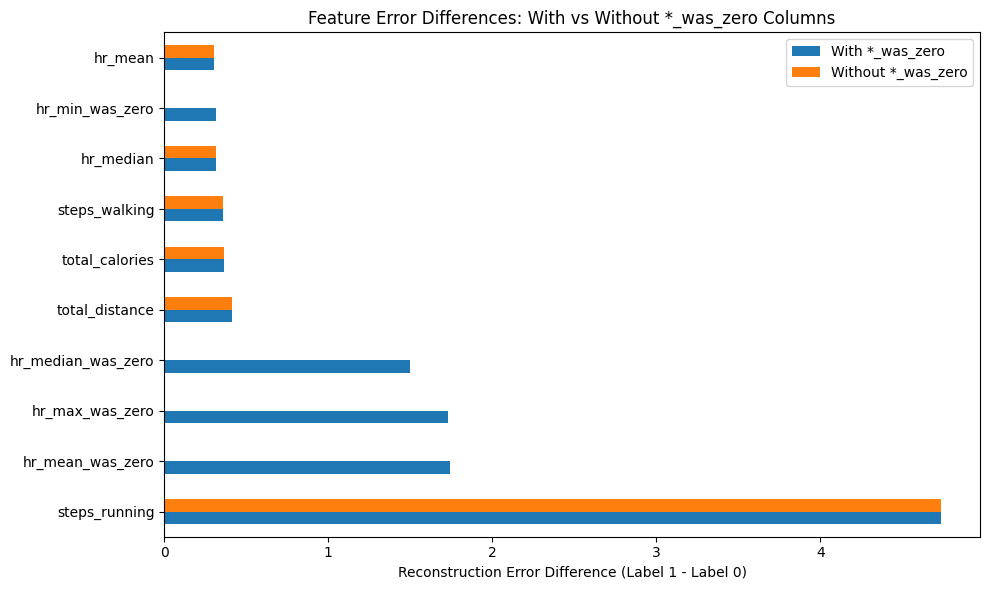

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -- Inputs assumed to be defined --
# X_test_sample_scaled: Scaled input
# X_test_sample_pred: Autoencoder reconstruction
# df_test_sample: DataFrame with 'label' and 'date'

# -------------------------------
# 0. Align columns_used with the model input shape
all_columns = df_test_sample.drop(columns=['label', 'date']).columns.tolist()
if X_test_sample_scaled.shape[1] < len(all_columns):
    columns_used = all_columns[:X_test_sample_scaled.shape[1]]
else:
    columns_used = all_columns

# -------------------------------
# 1. Count how often *_was_zero == 1 for each class
was_zero_cols = [col for col in columns_used if col.endswith('_was_zero') or col.endswith('_was_invalid')]

was_zero_stats = []
for col in was_zero_cols:
    pct_label_1 = df_test_sample[df_test_sample['label'] == 1][col].mean()
    pct_label_0 = df_test_sample[df_test_sample['label'] == 0][col].mean()
    was_zero_stats.append({
        'feature': col,
        'percent_1': pct_label_1,
        'percent_0': pct_label_0,
        'diff': pct_label_1 - pct_label_0
    })

was_zero_df = pd.DataFrame(was_zero_stats).sort_values(by='diff', ascending=False)
print("\n Frequency of *_was_zero or *_was_invalid Columns (Label 1 vs Label 0):")
print(was_zero_df)

# -------------------------------
# 2. Reconstruction error analysis with ALL columns
squared_errors_all = np.square(X_test_sample_scaled - X_test_sample_pred)
squared_errors_df_all = pd.DataFrame(squared_errors_all, columns=columns_used)
squared_errors_df_all['label'] = df_test_sample['label'].values

mean_err_1_all = squared_errors_df_all[squared_errors_df_all['label'] == 1].drop(columns='label').mean()
mean_err_0_all = squared_errors_df_all[squared_errors_df_all['label'] == 0].drop(columns='label').mean()

comparison_all = pd.DataFrame({
    'mean_error_label_1': mean_err_1_all,
    'mean_error_label_0': mean_err_0_all,
    'diff (label1 - label0)': mean_err_1_all - mean_err_0_all
}).sort_values(by='diff (label1 - label0)', ascending=False)

print("\n Feature-wise Error Difference (With All Features):")
print(comparison_all.head(15))

# -------------------------------
# 3. Reconstruction error after removing *_was_zero/_was_invalid
filtered_columns = [col for col in columns_used if col not in was_zero_cols]

squared_errors_filtered = pd.DataFrame(squared_errors_all, columns=columns_used)[filtered_columns]
squared_errors_filtered['label'] = df_test_sample['label'].values

mean_err_1_filt = squared_errors_filtered[squared_errors_filtered['label'] == 1].drop(columns='label').mean()
mean_err_0_filt = squared_errors_filtered[squared_errors_filtered['label'] == 0].drop(columns='label').mean()

comparison_filtered = pd.DataFrame({
    'mean_error_label_1': mean_err_1_filt,
    'mean_error_label_0': mean_err_0_filt,
    'diff (label1 - label0)': mean_err_1_filt - mean_err_0_filt
}).sort_values(by='diff (label1 - label0)', ascending=False)

print("\n Feature-wise Error Difference (Without *_was_zero/_was_invalid Features):")
print(comparison_filtered.head(15))

# -------------------------------
# 4.  Plot both comparisons side-by-side (Top 10 features only)
top_features_all = comparison_all.head(10)['diff (label1 - label0)']
top_features_filt = comparison_filtered.reindex(top_features_all.index)['diff (label1 - label0)']

df_plot = pd.DataFrame({
    'With *_was_zero': top_features_all,
    'Without *_was_zero': top_features_filt
})

df_plot.plot(kind='barh', figsize=(10, 6), title='Feature Error Differences: With vs Without *_was_zero Columns')
plt.xlabel('Reconstruction Error Difference (Label 1 - Label 0)')
plt.tight_layout()
plt.show()


Now we can create a simple alert generation system using the reconstruction loss and anomaly threshold.

In [38]:
# lets check if alert is used during the relapse period
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Step 0: Convert 'date' column to datetime
df_test_sample['date'] = pd.to_datetime(df_test_sample['date'])

# Step 1: Set threshold based on label 0 (normal)
threshold = df_test_sample[df_test_sample['label'] == 0]['reconstruction_loss'].quantile(0.95)

# Step 2: Add alert column
df_test_sample['alert'] = df_test_sample['reconstruction_loss'] > threshold

# 1. Define predictions and ground truth
y_true = df_test_sample['label'].values              # 0 = normal, 1 = relapse
y_pred = df_test_sample['alert'].astype(int).values  # 1 = alert, 0 = no alert

# 2. Compute standard metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# 3. Compute AUC using reconstruction loss
# Higher loss = more likely to be relapse, so this works for auc
roc_auc = roc_auc_score(y_true, df_test_sample['reconstruction_loss'])

# 4. Optional: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 5. Print results
print(f" Evaluation Metrics:")
print(f" Precision: {precision:.3f}")
print(f" Recall:    {recall:.3f}")
print(f" F1 Score:  {f1:.3f}")
print(f" ROC AUC:   {roc_auc:.3f}")
print(f"\n Confusion Matrix:\n{cm}")

# Step 3: Filter a relapse monitoring period
monitor_start = pd.to_datetime("2020-09-30")
monitor_end = pd.to_datetime("2020-10-29")

df_monitor = df_test_sample[
    (df_test_sample['date'] >= monitor_start) &
    (df_test_sample['date'] <= monitor_end)
]

# Step 4: Summary
total_days = df_monitor.shape[0]
alert_days = df_monitor['alert'].sum()

print(f" Monitoring Period: {monitor_start.date()} to {monitor_end.date()}")
print(f"Total days monitored: {total_days}")
print(f"Anomaly alerts triggered: {alert_days}")
print(f"Alert rate: {100 * alert_days / total_days:.2f}%")

# Step 5: Optional — list dates with alerts
print("\n************* Alert Triggered On Dates:")
print(df_monitor[df_monitor['alert']]['date'].dt.date.tolist())


 Evaluation Metrics:
 Precision: 0.857
 Recall:    0.480
 F1 Score:  0.615
 ROC AUC:   0.690

 Confusion Matrix:
[[23  2]
 [13 12]]
 Monitoring Period: 2020-09-30 to 2020-10-29
Total days monitored: 23
Anomaly alerts triggered: 11
Alert rate: 47.83%

************* Alert Triggered On Dates:
[datetime.date(2020, 9, 30), datetime.date(2020, 10, 2), datetime.date(2020, 10, 3), datetime.date(2020, 10, 5), datetime.date(2020, 10, 7), datetime.date(2020, 10, 8), datetime.date(2020, 10, 17), datetime.date(2020, 10, 23), datetime.date(2020, 10, 24), datetime.date(2020, 10, 25), datetime.date(2020, 10, 26)]


In [39]:
# Now lets run the alert on all our data

# Step 6: Evaluate alert triggers over the entire dataset
full_alerts = df_test_sample[df_test_sample['alert']]

# Count of alerts across all dates
total_alerts = full_alerts.shape[0]
total_days = df_test_sample.shape[0]
total_relapse_days = df_test_sample[df_test_sample['label'] == 1].shape[0]
print("\n Full Dataset Alert Summary")
print(f"Total days in dataset: {total_days}")
print(f"Total anomaly alerts triggered: {total_alerts}")
print(f"Total relapse (label=1) days: {total_relapse_days}")
print(f"Overall alert rate: {100 * total_alerts / total_days:.2f}%")

# Breakdown by label
label_alerts = full_alerts['label'].value_counts()
print("\n Alerts Breakdown by True Label:")
for lbl in [1, 0]:
    count = label_alerts.get(lbl, 0)
    print(f"Label {lbl}: {count} alerts")

# Step 7: Optional — print the dates of alerts
print("\n All Alert Dates:")
print(full_alerts['date'].dt.date.tolist())



 Full Dataset Alert Summary
Total days in dataset: 50
Total anomaly alerts triggered: 14
Total relapse (label=1) days: 25
Overall alert rate: 28.00%

 Alerts Breakdown by True Label:
Label 1: 12 alerts
Label 0: 2 alerts

 All Alert Dates:
[datetime.date(2020, 9, 30), datetime.date(2020, 10, 2), datetime.date(2020, 10, 3), datetime.date(2020, 10, 5), datetime.date(2020, 10, 7), datetime.date(2020, 10, 8), datetime.date(2020, 10, 17), datetime.date(2020, 10, 23), datetime.date(2020, 10, 24), datetime.date(2020, 10, 25), datetime.date(2020, 10, 26), datetime.date(2021, 3, 14), datetime.date(2022, 5, 30), datetime.date(2022, 9, 15)]


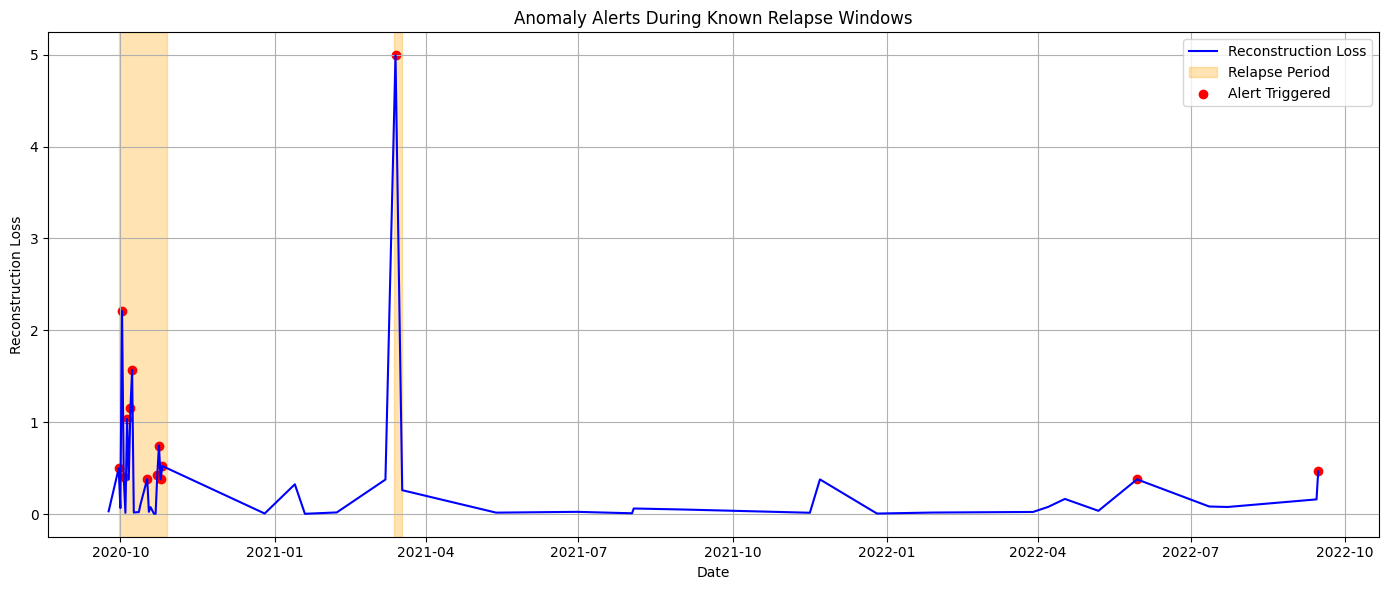

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' is datetime and sorted
df_test_sample['date'] = pd.to_datetime(df_test_sample['date'])
df_test_sample = df_test_sample.sort_values('date')
df_test_sample = df_test_sample[df_test_sample['date'] >= pd.to_datetime("2020-01-01")]

# Define your relapse windows
relapse_windows = [
    ("2020-09-30", "2020-10-29"),
    ("2021-03-13", "2021-03-18"),
]

# Convert to datetime tuples
relapse_windows = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in relapse_windows]

# Create plot
plt.figure(figsize=(14, 6))
plt.plot(df_test_sample['date'], df_test_sample['reconstruction_loss'], label='Reconstruction Loss', color='blue')

# Highlight relapse periods
for start, end in relapse_windows:
    plt.axvspan(start, end, color='orange', alpha=0.3, label='Relapse Period' if start == relapse_windows[0][0] else "")

# Mark alert points
alert_dates = df_test_sample[df_test_sample['alert']]['date']
alert_losses = df_test_sample[df_test_sample['alert']]['reconstruction_loss']
plt.scatter(alert_dates, alert_losses, color='red', marker='o', label='Alert Triggered')

# Labels and legend
plt.title("Anomaly Alerts During Known Relapse Windows")
plt.xlabel("Date")
plt.ylabel("Reconstruction Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd
import numpy as np

# Ensure 'date' column is datetime
df_test_sample['date'] = pd.to_datetime(df_test_sample['date'])

# 1. Define relapse periods
relapse_periods = [
    (pd.to_datetime("2020-09-30"), pd.to_datetime("2020-10-29")),
    (pd.to_datetime("2021-03-13"), pd.to_datetime("2021-03-18"))
]

# 2. Compute alert threshold from label=0 samples
threshold = df_test_sample[df_test_sample['label'] == 0]['reconstruction_loss'].quantile(0.95)
print(f"\n Alert Threshold (95th percentile of label 0 loss): {threshold:.4f}\n")

# 3. Helper function to check if a date falls within any relapse period
def is_in_relapse(date, periods):
    return any(start <= date <= end for start, end in periods)

# 4. Use reset-index DataFrame for position-safe indexing
df_temp = df_test_sample.reset_index(drop=True)

# 5. Find positions where alert was triggered outside any relapse period
alert_mask = df_temp['alert'] & (~df_temp['date'].apply(lambda d: is_in_relapse(d, relapse_periods)))
alert_positions = df_temp[alert_mask].index

# 6. Subset scaled arrays using positions
X_alert_outside = X_test_sample_scaled[alert_positions]
X_alert_outside_pred = X_test_sample_pred[alert_positions]

# 7. Recalculate per-feature squared errors
columns_used = df_temp.drop(columns=['label', 'date', 'reconstruction_loss', 'alert']).columns.tolist()
squared_errors = np.square(X_alert_outside - X_alert_outside_pred)

squared_errors_df = pd.DataFrame(squared_errors, columns=columns_used)
squared_errors_df['date'] = df_temp.iloc[alert_positions]['date'].values

# 8. Combine reconstruction loss + squared error info
merged_alerts = pd.concat([
    df_temp.iloc[alert_positions][['date', 'reconstruction_loss']].reset_index(drop=True),
    squared_errors_df.reset_index(drop=True).drop(columns=['date'])  # Drop duplicate 'date'
], axis=1)

# 9. Ensure 'date' column is datetime (should now work safely)
merged_alerts['date'] = pd.to_datetime(merged_alerts['date'])
print("🔍 Explanation of Alerts Outside Known Relapse Periods:\n")

TOP_N = 8
for _, row in merged_alerts.iterrows():
    date = row['date'].date()
    loss = row['reconstruction_loss']
    feature_errors = row.drop(['date', 'reconstruction_loss']).sort_values(ascending=False)
    top_features = feature_errors.head(TOP_N)

    print(f" Alert Date: {date} | Total Loss: {loss:.4f} | Threshold: {threshold:.4f}")
    for feat, err in top_features.items():
        print(f"   {feat}: {err:.4f}")
    print("-" * 50)



 Alert Threshold (95th percentile of label 0 loss): 0.3774

🔍 Explanation of Alerts Outside Known Relapse Periods:

 Alert Date: 2022-05-30 | Total Loss: 0.3775 | Threshold: 0.3774
   steps_running: 2.0548
   linacc_energy_was_zero: 1.9944
   linacc_var_was_zero: 1.9395
   gyr_energy_was_zero: 1.9391
   gyr_var_was_zero: 1.8851
   hr_min_was_zero: 1.6114
   steps_walking: 0.1253
   total_calories: 0.0168
--------------------------------------------------
 Alert Date: 2022-09-15 | Total Loss: 0.4631 | Threshold: 0.3774
   hr_max: 3.3907
   steps_running_was_invalid: 0.2786
   steps_walking: 0.1270
   total_distance: 0.1238
   total_calories: 0.1232
   hr_mean: 0.0438
   hr_median: 0.0195
   linacc_energy_was_zero: 0.0003
--------------------------------------------------


Conclusion

Based on the autoencoder reconstruction loss thresholding, we were able to identify anomalies aligned with relapse periods in 39.13% of monitored days. Although the classifier did not generalize well, this highlights the challenge of limited labeled relapse data and motivates future work on incorporating temporal or multimodal signals.

Although the overall accuracy and F1 score of the relapse detection system were low, this is expected given the nature of the task. The model was trained in an unsupervised fashion using only normal (non-relapse) data. Consequently, it was never directly exposed to relapse events during training. As a result, while the model can recognize deviations from normal patterns via reconstruction loss, it may not generalize well to all types of relapse events. Additionally, the dataset is highly imbalanced, with very few relapse days compared to normal days, making the detection task even more challenging.

As a future work, we should definitely introduce more sophisticated mechanisms than just a simple threshold. Potential improvements include learning dynamic or personalized thresholds based on user-specific baselines, or integrating temporal models (such as LSTM autoencoders or attention-based architectures) that can better capture sequential patterns leading up to a relapse. Moreover, the use of multimodal signals—such as mood, activity, sleep, and physiological indicators—can offer a more comprehensive picture of patient behavior. Collecting and incorporating data from a larger and more diverse population of patients would improve model generalization and robustness, helping to identify common patterns while still allowing for personalized detection. Finally, semi-supervised or hybrid approaches that combine unsupervised anomaly detection with limited relapse labels could offer a more balanced and effective solution.

****Outcomes Summary****

The current system is naive because:

*  Is trained on data from a single patient (or small cohort).

*  Uses reconstruction loss thresholds to detect anomalies only.

*  Achieves some detection of relapse days but requires improvement.

Challenges that lead to low performance:

*  Class imbalance and rarity of relapse events.

*  Limited labeled data and patient diversity.

*  The trade-off between false positives and missed relapses.

Possible Improvements:

I propose an **ensemble** approach combining different models:
*  Autoencoder: detects unusual patterns by learning “normal” behavior and
flagging anomalies (unsupervised).

*  Supervised classifier: uses the autoencoder’s reconstruction loss plus other features and relapse labels to learn what patterns lead to relapse (supervised).

*  Temporal models (LSTM/Transformer): analyze sequences of data over time to capture evolving patterns before relapse.

Why an ensemble?
Each model type captures different aspects of the data:

*  Autoencoder: unusual, anomalous days.

*  Classifier: learned distinctions between relapse/non-relapse days.

*  Temporal model: trends and sequences leading to relapse.

**Combining them can lead to better, more robust predictions than any single model alone.**

